# AI300 Capstone - XGBoost Model (Not Selected)

I selected Catboost as it was quicker at making prediction and also better at handling the categorical features without encoding. AUC performance was roughly par. <br> <br> I later realized that XGBoost also has an experimental 'enable_cateogrical' feature, which is why I have steps to encode my data to be fed into the Classifier.

## Importing Required Packages

In [3]:
# for EDA
import pandas as pd
import numpy as np
import statistics

# for visualizations
import plotly.express as px 
import matplotlib.pyplot as plt
# import plotly.figure_factory as ff

# data ingest from db
import sqlalchemy 
from sqlalchemy import create_engine

# for ML
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.model_selection import KFold, GridSearchCV,StratifiedKFold, train_test_split
import shap
# from sklearn.model_selection import Kfold

## Data Ingest from CSV

In [4]:
train_df = pd.read_csv("data/rawdata.csv") # data extracted from SQL DB and accessed from local machine
train_df.head(5)

,customer_id,status,churn_label,churn_category,churn_reason,account_id,customer_id.1,tenure_months,num_referrals,has_internet_service,...,senior_citizen,married,num_dependents,zip_code,area_id,zip_code.1,city,latitutde,longitude,population
0,0013-EXCHZ,Churned,Yes,Dissatisfaction,Network reliability,BFIN-DLMOA,0013-EXCHZ,3,3,Yes,...,Yes,Yes,0,93010,607,93010,Camarillo,34.227846,-119.079903,42853
1,0014-BMAQU,Stayed,No,NaN,NaN,AFEO-XOOCP,0014-BMAQU,63,8,Yes,...,No,Yes,0,94558,963,94558,Napa,38.489789,-122.270110,63947
2,0016-QLJIS,Stayed,No,NaN,NaN,DEMQ-MFXWC,0016-QLJIS,65,3,Yes,...,No,Yes,1,95681,1390,95681,Sheridan,38.984756,-121.345074,1219
3,0019-EFAEP,Stayed,No,NaN,NaN,AIPP-VTDXJ,0019-EFAEP,72,0,Yes,...,No,No,0,91942,303,91942,La Mesa,32.782501,-117.016110,24005
4,0019-GFNTW,Stayed,No,NaN,NaN,CJHA-SRKIB,0019-GFNTW,56,0,Yes,...,No,No,0,93441,716,93441,Los Olivos,34.704340,-120.026090,1317


## EDA

In [5]:
train_df = train_df[train_df['status'] != 'Joined'] # drop recently joined users 
train_df = train_df[train_df['churn_label'].notnull()] # drop missing values

# impute any NaN with '' for cols with string dtype
for col in train_df.select_dtypes(include='object').columns.values:
    train_df[col] = train_df[col].fillna('')

train_df.head(5)

,customer_id,status,churn_label,churn_category,churn_reason,account_id,customer_id.1,tenure_months,num_referrals,has_internet_service,...,senior_citizen,married,num_dependents,zip_code,area_id,zip_code.1,city,latitutde,longitude,population
0,0013-EXCHZ,Churned,Yes,Dissatisfaction,Network reliability,BFIN-DLMOA,0013-EXCHZ,3,3,Yes,...,Yes,Yes,0,93010,607,93010,Camarillo,34.227846,-119.079903,42853
1,0014-BMAQU,Stayed,No,,,AFEO-XOOCP,0014-BMAQU,63,8,Yes,...,No,Yes,0,94558,963,94558,Napa,38.489789,-122.270110,63947
2,0016-QLJIS,Stayed,No,,,DEMQ-MFXWC,0016-QLJIS,65,3,Yes,...,No,Yes,1,95681,1390,95681,Sheridan,38.984756,-121.345074,1219
3,0019-EFAEP,Stayed,No,,,AIPP-VTDXJ,0019-EFAEP,72,0,Yes,...,No,No,0,91942,303,91942,La Mesa,32.782501,-117.016110,24005
4,0019-GFNTW,Stayed,No,,,CJHA-SRKIB,0019-GFNTW,56,0,Yes,...,No,No,0,93441,716,93441,Los Olivos,34.704340,-120.026090,1317


In [6]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure_months,6537.0,34.632094,23.962097,1.000000,12.000000,32.000000,57.000000,72.000000
num_referrals,6537.0,2.031819,3.031187,0.000000,0.000000,0.000000,3.000000,11.000000
avg_long_distance_fee_monthly,6537.0,23.000407,15.470337,0.000000,9.260000,22.920000,36.440000,49.990000
total_long_distance_fee,6537.0,801.189875,855.146776,0.000000,108.160000,475.680000,1280.980000,3564.720000
avg_gb_download_monthly,6537.0,20.897659,20.423996,0.000000,4.000000,17.000000,27.000000,85.000000
total_monthly_fee,6537.0,66.148180,29.946916,18.250000,40.350000,72.450000,90.550000,118.750000
total_charges_quarter,6537.0,2439.689344,2267.891087,18.850000,551.300000,1567.000000,4016.200000,8684.800000
total_refunds,6537.0,2.097491,8.155182,0.000000,0.000000,0.000000,0.000000,49.790000
age,6537.0,46.740095,16.843125,19.000000,33.000000,46.000000,60.000000,80.000000
num_dependents,6537.0,0.478354,0.970431,0.000000,0.000000,0.000000,0.000000,9.000000


In [8]:
viz_df = train_df
fig = px.histogram(viz_df,
                   x='total_charges_quarter',
                   color='churn_label'
                  )
fig.show()

In [9]:
viz_df = train_df

fig = px.histogram(viz_df,
                   x='tenure_months',
                   color='status',
                   barnorm='percent',
#                    marginal = 'histogram'
                  )
fig.show()

fig = px.histogram(viz_df,
                   x='tenure_months',
                   color='status',
#                    barnorm='percent',
#                    marginal = 'histogram'
                  )
fig.show()

In [10]:
viz_df = train_df

fig = px.histogram(viz_df,
                   x='total_monthly_fee',
#                  y='total_refunds',
                   color='status',
                  )
fig.show()

## Impute and Filtering

In [11]:
train_df = train_df[train_df['status'] != 'Joined'] # drop recently joined users 
train_df = train_df[train_df['churn_label'].notnull()]
train_df = train_df.drop(labels=['status',
                                 'churn_category',
                                 'churn_reason',
                                 'customer_id',
                                 'account_id'],
                                 axis=1)
train_df.head(5)

,churn_label,customer_id.1,tenure_months,num_referrals,has_internet_service,internet_type,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,...,senior_citizen,married,num_dependents,zip_code,area_id,zip_code.1,city,latitutde,longitude,population
0,Yes,0013-EXCHZ,3,3,Yes,Fiber Optic,Yes,Yes,No,Yes,...,Yes,Yes,0,93010,607,93010,Camarillo,34.227846,-119.079903,42853
1,No,0014-BMAQU,63,8,Yes,Fiber Optic,No,Yes,Yes,Yes,...,No,Yes,0,94558,963,94558,Napa,38.489789,-122.270110,63947
2,No,0016-QLJIS,65,3,Yes,Cable,Yes,Yes,Yes,Yes,...,No,Yes,1,95681,1390,95681,Sheridan,38.984756,-121.345074,1219
3,No,0019-EFAEP,72,0,Yes,Fiber Optic,Yes,Yes,Yes,No,...,No,No,0,91942,303,91942,La Mesa,32.782501,-117.016110,24005
4,No,0019-GFNTW,56,0,Yes,DSL,Yes,No,No,Yes,...,No,No,0,93441,716,93441,Los Olivos,34.704340,-120.026090,1317


## Feature Encoding

In [12]:
# OHE
ohe_cols = ['has_internet_service',
            'internet_type',
            'contract_type',
            'payment_method',
            'zip_code',
            'area_id'
           ]

label_encode_cols = ['churn_label',
                     'has_unlimited_data',
                     'has_phone_service',
                     'has_multiple_lines',
                     'has_premium_tech_support',
                     'has_online_security',
                     'has_online_backup',
                     'has_device_protection',
                     'stream_tv',
                     'stream_movie',
                     'stream_music',
                     'gender',
                     'senior_citizen',
                     'married',
                     'paperless_billing'
                    ]

In [13]:
def onehotencoder(cols,df):
    for col in cols:
        OH_encode = pd.get_dummies(df[col],prefix='ohe_')
        df = pd.concat([df, OH_encode], axis=1)
        df.drop(col, axis='columns', inplace=True)
        print(col + ' has been OH encoded and dropped')
    return df

def labelencodedf(cols,df):
    for col in cols:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
        print('encoded - ' + col)
    return df

In [14]:
df_ohe = onehotencoder(ohe_cols,train_df)
df_ohe.head(5)

has_internet_service has been OH encoded and dropped
internet_type has been OH encoded and dropped
contract_type has been OH encoded and dropped
payment_method has been OH encoded and dropped
zip_code has been OH encoded and dropped
area_id has been OH encoded and dropped


,churn_label,customer_id.1,tenure_months,num_referrals,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,has_online_backup,...,ohe__1617,ohe__1618,ohe__1619,ohe__1620,ohe__1621,ohe__1622,ohe__1623,ohe__1624,ohe__1625,ohe__1626
0,Yes,0013-EXCHZ,3,3,Yes,Yes,No,Yes,No,No,...,False,False,False,False,False,False,False,False,False,False
1,No,0014-BMAQU,63,8,No,Yes,Yes,Yes,Yes,No,...,False,False,False,False,False,False,False,False,False,False
2,No,0016-QLJIS,65,3,Yes,Yes,Yes,Yes,Yes,Yes,...,False,False,False,False,False,False,False,False,False,False
3,No,0019-EFAEP,72,0,Yes,Yes,Yes,No,Yes,Yes,...,False,False,False,False,False,False,False,False,False,False
4,No,0019-GFNTW,56,0,Yes,No,No,Yes,Yes,Yes,...,False,False,False,False,False,False,False,False,False,False


In [15]:
df_ohe_le = labelencodedf(label_encode_cols,df_ohe)
df_ohe_le.head(5)

encoded - churn_label
encoded - has_unlimited_data
encoded - has_phone_service
encoded - has_multiple_lines
encoded - has_premium_tech_support
encoded - has_online_security
encoded - has_online_backup
encoded - has_device_protection
encoded - stream_tv
encoded - stream_movie
encoded - stream_music
encoded - gender
encoded - senior_citizen
encoded - married
encoded - paperless_billing


,churn_label,customer_id.1,tenure_months,num_referrals,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,has_online_backup,...,ohe__1617,ohe__1618,ohe__1619,ohe__1620,ohe__1621,ohe__1622,ohe__1623,ohe__1624,ohe__1625,ohe__1626
0,1,0013-EXCHZ,3,3,1,1,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,0014-BMAQU,63,8,0,1,1,1,1,0,...,False,False,False,False,False,False,False,False,False,False
2,0,0016-QLJIS,65,3,1,1,1,1,1,1,...,False,False,False,False,False,False,False,False,False,False
3,0,0019-EFAEP,72,0,1,1,1,0,1,1,...,False,False,False,False,False,False,False,False,False,False
4,0,0019-GFNTW,56,0,1,0,0,1,1,1,...,False,False,False,False,False,False,False,False,False,False


## Modelling with XGboost

In [17]:
# preparing final df for model training
X = df_ohe_le.drop(labels='churn_label',
                           axis=1)
X = X.drop(X.select_dtypes(include='object').columns,axis=1)
y = df_ohe_le['churn_label']

**XGBoost with Kfold**
<br> *Simple XGBoost with Kfold as a pilot model*

In [18]:
N_ESTIMATORS = 100
RANDOM_STATE = 0

xgb = XGBClassifier(
                    max_depth = 5,
                    random_state=RANDOM_STATE,
                    n_estimators = N_ESTIMATORS,
                    verbosity = 1,
                    eval_metric = 'auc'
                    )

def k_fold_validation(regressor, X, y):
    kf = KFold(n_splits=5)
    k_fold_auc = []

    for train_index, test_index in kf.split(X):

        # Extract the training and test data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit model
        model = regressor.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)

        #Calculate RMSE for the fold and append it
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
        k_fold_auc.append(auc(fpr,tpr).round(4))
        
    return 'Average AUC: ' + str({statistics.mean(k_fold_auc)})

k_fold_validation(xgb,X,y)

0.9344
0.9292
0.936


**XGboost with GridSearch**

In [25]:
N_ESTIMATORS = 100
RANDOM_STATE = 0

params_grid = {
          'learning_rate':[0.01,0.1,0.15],
          'max_depth': [3,4,5],
          'tree_method': ['approx'],
          'objective':['binary:logistic']
        }

xgb = XGBClassifier(random_state=RANDOM_STATE,
                    n_estimators=N_ESTIMATORS,     
                   )

grid = GridSearchCV(xgb,
                    params_grid,
                    scoring='f1',
                    refit = True,
                    cv=5
                   ) 
grid.fit(X, y)
# print(grid.cv_results_)
print(grid.best_score_)
print(grid.best_estimator_)

0.7832569181086467
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)


In [ ]:
print(grid.best_params_)
print(gri.best_estimator_)

## Feature Importance Evaluation

Features by Feature Importance
ohe__Month-to-Month         0.485668
tenure_months               0.059775
num_dependents              0.038680
num_referrals               0.033535
ohe__Two Year               0.031484
ohe__Credit Card            0.028783
ohe__One Year               0.023396
age                         0.022038
paperless_billing           0.020740
total_monthly_fee           0.020537
stream_movie                0.018688
has_online_security         0.014417
married                     0.014369
has_premium_tech_support    0.013967
ohe__92122                  0.010194
dtype: float32


<function matplotlib.pyplot.show(close=None, block=None)>

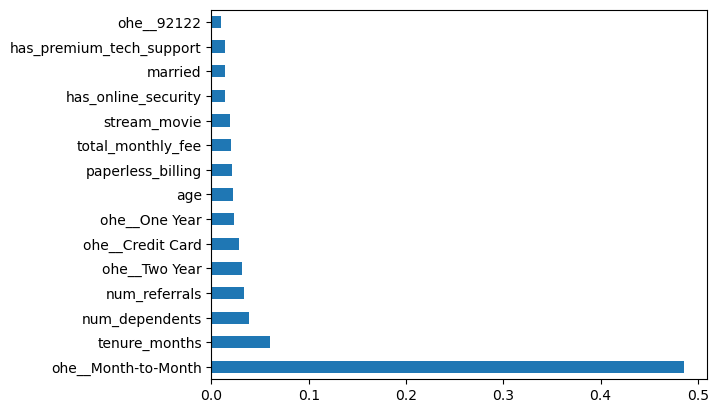

In [27]:
feat_importances = pd.Series(grid.best_estimator_.feature_importances_,index=X.columns).sort_values(ascending=False)
feat_importances.nlargest(15).plot(kind='barh')
print('Features by Feature Importance')
print(feat_importances.nlargest(15))
plt.show

In [28]:
explainer = shap.Explainer(grid.best_estimator_)
shap_values = explainer(X)
# shap_values = explainer.shap_values(X)

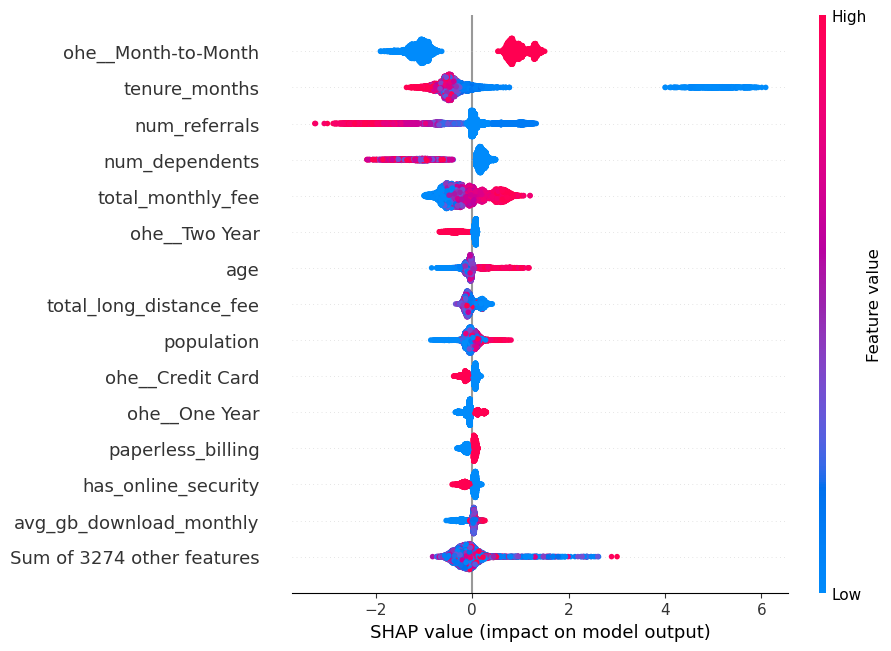

In [29]:
shap.plots.beeswarm(shap_values,max_display=15)

## Testing XGboost with Top N Features by AUC

In [30]:
# xgb_df = train_df

xgb = XGBClassifier(
                    learning_rate=0.15,
                    max_depth = 3,
                    random_state=42,
                    n_estimators = 100,
                    eval_metric = 'auc',
                    objective = 'binary:logistic',
                    )


def k_fold_validation(regressor, X, y):
    kf = KFold(n_splits=5)
    k_fold_auc = []

    for train_index, test_index in kf.split(X):

        # Extract the training and test data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit model
        model = regressor.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)

        #Calculate AUC for the fold and append it
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
        k_fold_auc.append(auc(fpr,tpr))
    return (i,statistics.mean(k_fold_auc))


auc_n_feature = {}


for i in range(1,20):
    cols_to_keep = feat_importances.nlargest(i).index.values.tolist() # to N features based on Feat impt
    xgb_X = X[cols_to_keep]
    
    auc_mean = k_fold_validation(xgb,xgb_X, y)
    auc_n_feature[i] = auc_mean

auc_n_feature

{1: (1, 0.7799703622900959),
 2: (2, 0.8441058296883859),
 3: (3, 0.8737771851747886),
 4: (4, 0.9081145361862328),
 5: (5, 0.9121453780040543),
 6: (6, 0.9179069797142716),
 7: (7, 0.918035121159999),
 8: (8, 0.9265947480111248),
 9: (9, 0.9283036511409237),
 10: (10, 0.9365909343429387),
 11: (11, 0.9371267064867594),
 12: (12, 0.9374513797401449),
 13: (13, 0.9373143092144663),
 14: (14, 0.9379304781490401),
 15: (15, 0.9385960539408101),
 16: (16, 0.939419764377078),
 17: (17, 0.9397026073653097),
 18: (18, 0.9387661085990885),
 19: (19, 0.9392167982465549)}

In [31]:
auc_by_feature = pd.DataFrame.from_dict(auc_n_feature,orient='index',columns=['num_features','mean_AUC'])
auc_by_feature['mean_AUC'] = auc_by_feature['mean_AUC'].round(3)

fig = px.line(auc_by_feature,
             x='num_features',
             y='mean_AUC',
             text='mean_AUC',
             title='Mean AUC of model by Top N Features')

fig.update_traces(textposition='top center')

fig.show()

In [32]:
feat_importances.nlargest(6).index.values.tolist() # features to use in app

['ohe__Month-to-Month',
 'tenure_months',
 'num_dependents',
 'num_referrals',
 'ohe__Two Year',
 'ohe__Credit Card']

## Testing XGBoost with Top N Features by F1 Score

In [50]:
# xgb_df = train_df

def k_fold_validation(regressor, X, y):
    kf = KFold(n_splits=5)
    k_fold_f1 = []

    for train_index, test_index in kf.split(X):

        # Extract the training and test data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit model
        model = regressor.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate f1
        f1 = f1_score(y_test, y_pred)
        k_fold_f1.append(f1)

    return (i,statistics.mean(k_fold_f1))

def f1_eval(y_pred, dtrain): #custom function to pass into XGB as eval_metric
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

xgb = XGBClassifier(
                    learning_rate=0.15,
                    max_depth = 3,
                    random_state=42,
                    n_estimators = 100,
                    eval_metric = f1_eval,
                    objective = 'binary:logistic',
                    )

f1_n_feature = {}

for i in range(1,16):
    cols_to_keep = feat_importances.nlargest(i).index.values.tolist() # to N features based on Feat impt
    xgb_X = X[cols_to_keep]
    f1_mean = k_fold_validation(xgb,xgb_X,y)
    f1_n_feature[i] = f1_mean

f1_n_feature

{1: (1, 0.6478386561690206),
 2: (2, 0.5266488794405229),
 3: (3, 0.5970742863073014),
 4: (4, 0.6591279035718335),
 5: (5, 0.6609434812999332),
 6: (6, 0.7119498046763025),
 7: (7, 0.7116299077756782),
 8: (8, 0.7314132408312465),
 9: (9, 0.7494144242702186),
 10: (10, 0.7617403143806457),
 11: (11, 0.762996384440958),
 12: (12, 0.7660204362767905),
 13: (13, 0.7649241841729605),
 14: (14, 0.7661575952949521),
 15: (15, 0.771266008990395)}

In [51]:
f1_by_feature = pd.DataFrame.from_dict(f1_n_feature,orient='index',columns=['num_features','mean_f1'])
f1_by_feature['mean_f1'] = f1_by_feature['mean_f1'].round(3)

fig = px.line(f1_by_feature,
             x='num_features',
             y='mean_f1',
             text='mean_f1',
             title='Mean F1 Score of model by Top N Features')

fig.update_traces(textposition='top center')

fig.show()


In [53]:
feat_importances.nlargest(10).index.values.tolist() # features to use in app

['ohe__Month-to-Month',
 'tenure_months',
 'num_dependents',
 'num_referrals',
 'ohe__Two Year',
 'ohe__Credit Card',
 'ohe__One Year',
 'age',
 'paperless_billing',
 'total_monthly_fee']